# First HW Assignment

Many of these exercises use data used in the book "Computer Age Statistical Inference" by Bradley Efron and Trevor Hastie. These datasets can be found on the book webpage https://web.stanford.edu/~hastie/CASI_files/DATA/.

In [2]:
# Installs
# conda install -c conda-forge asteval
# conda install -c conda-forge lmfit

In [2]:
#******************************************************************************#
# Futures
%matplotlib inline
# from __future__ import unicode_literals
# from __future__ import print_function

# Generic/Built-in
import datetime
import argparse

# Other Libs
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from IPython.display import display, Image
from matplotlib.collections import LineCollection
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from scipy import stats

# Owned
# from nostalgia_util import log_utils
# from nostalgia_util import settings_util
__authors__   = ["Osamu Katagiri - A01212611@itesm.mx"]
__copyright__ = "None"
__credits__   = ["José Luis Preciado Arreola - jlpreciadoarreola@tec.mx"]
__license__   = "None"
__status__    = "Under Work"
__data__      = "https://web.stanford.edu/~hastie/CASI_files/DATA/"
#******************************************************************************#

# Chapter 1

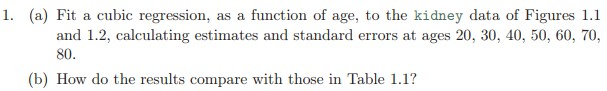

In [3]:
display(Image(filename='./directions/1.1.jpg'))

## Chapter 1 - Exercice 1.a

In [4]:
'''Kidney fitness data of Figure 1.1
Measurements on 157 healthy volunteers (potential donors)
These data originated in the nephrology
laboratory of Dr. Brian Myers, Stanford University

age: of volunteer
tot: composite meaure of overall kidney function'''

# load the data
#kidney = pd.read_csv(__data__ + "kidney.txt", delimiter=" ")
kidney = pd.read_csv("./data/kidney.txt", delimiter=" ")

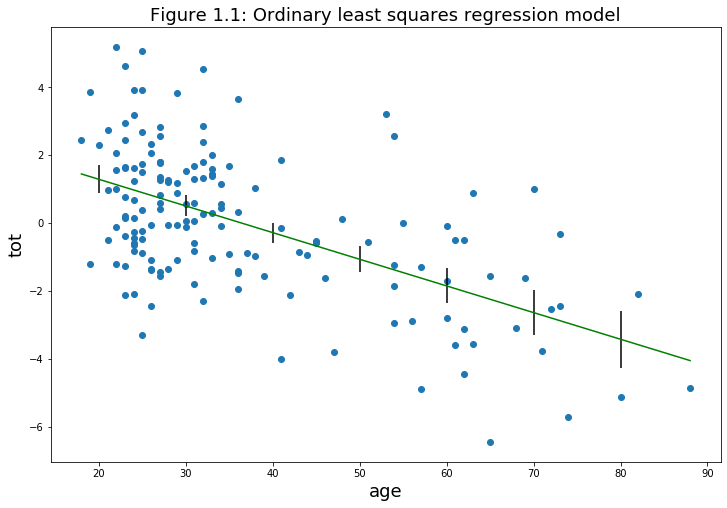

In [5]:
#******************************************************************************#
### Ordinary least squares regression model

# Fit the model
model = smf.ols(formula="tot ~ age", data=kidney)
results = model.fit()

# Create predictions for the regression line
sorted_kidney = kidney.sort_values("age")
OLS_tot_pred = results.predict(sorted_kidney)

# Get predictions and standard error for ages 20, 30, ..., 80
decades = pd.DataFrame({"age": range(20, 90, 10)})
OLS_pred = results.get_prediction(decades)
OLS_pred_info = OLS_pred.summary_frame()
OLS_pred_info.index = decades.age

# Collect info for standard error lines
OLS_se_lines = LineCollection(
    [
        [[age, OLS_pred - 2 * se], [age, OLS_pred + 2 * se]]
        for age, OLS_pred, se in zip(OLS_pred_info.index, OLS_pred_info["mean"], OLS_pred_info["mean_se"])
    ],
    color="k"
)

# Figure 1.1
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(kidney.age, kidney.tot)
ax.plot(sorted_kidney.age, OLS_tot_pred, color="g")
ax.add_collection(OLS_se_lines)

ax.set_title("Figure 1.1: Ordinary least squares regression model", size=18)
ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18);

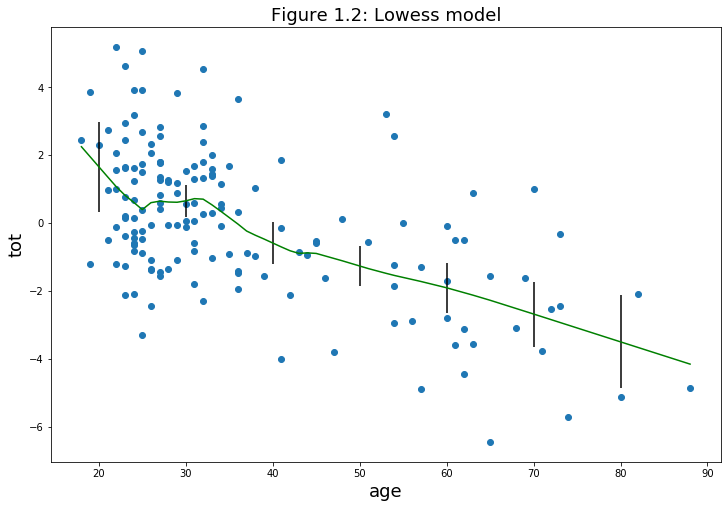

In [6]:
#******************************************************************************#
### Lowess model

low_preds = lowess(kidney.tot, kidney.age, frac=1/3.0)

# Create 250 bootstrap samples of the lowess predictions
low_boots = []
for i in range(250):
    boot_data = kidney.sample(n=kidney.shape[0], replace=True)
    new_preds = lowess(boot_data.tot, boot_data.age, frac=1/3.0)
    low_boots.append(new_preds)
    
# Get bootstrap standard deviation as an estimate of standard error

''' As mentioned above, the return value from lowess is an array of input
x-values (age) and fit lowess values (tot). To get the fit lowess value at a
particular age, we need to interpolate or extrapolate from the ages in the
returned array. We can't assume an age value we're interested in is one of the
input x-values '''

ages = np.array(list(range(20, 90, 10)))

# interpolate lowess predictions for age = 20, 30, ..., 80
dec_preds = np.zeros((7, 250))
for i, pred in enumerate(low_boots):
    # interp1d seems to have trouble with non-unique values
    pred = np.unique(pred, axis=0)
    # create an interpolator and collect each lowess's predictions
    interpolate = interp1d(pred[:, 0], pred[:, 1], fill_value="extrapolate", assume_sorted=True)
    dec_preds[:, i] = interpolate(ages)

# get standard deviation for each age
var = np.var(dec_preds, axis=1, ddof=1)
low_sds = np.sqrt(var)

# Collect info for standard error lines
# interpolate/predict from the original lowess predictions
interpolate = interp1d(
    low_preds[:, 0],
    low_preds[:, 1],
    fill_value="extrapolate",
    assume_sorted=True
)

low_se_lines = LineCollection(
    [
        [[age, interpolate(age) - 2 * se], [age, interpolate(age) + 2 * se]]
        for age, se in zip(ages, low_sds)
    ],
    color="k"
)

# Figure 1.2
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(kidney.age, kidney.tot)
ax.plot(low_preds[:, 0], low_preds[:, 1], color="g")
ax.add_collection(low_se_lines)

ax.set_title("Figure 1.2: Lowess model", size=18)
ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18);

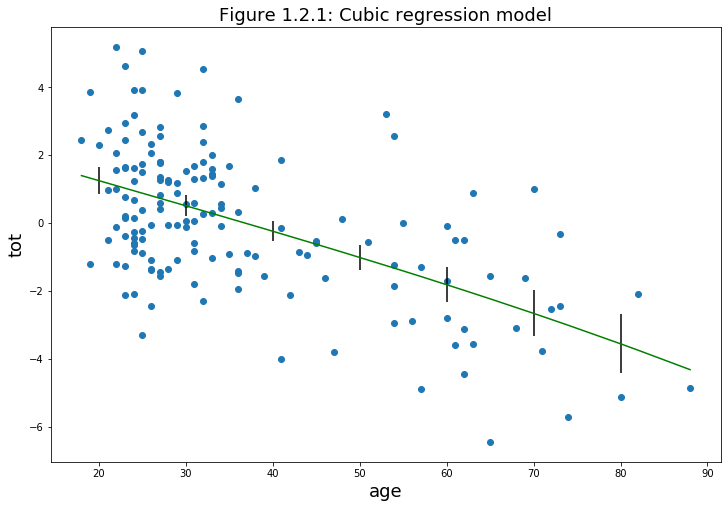

In [7]:
#******************************************************************************#
### Cubic regression model

x = kidney.age
y = kidney.tot
degree = 3
weights = np.polyfit(x, y, degree)
polynomial = np.poly1d(weights)

# Fit the model
cubic_model = smf.ols(formula='tot ~ polynomial(age)', data=kidney)
cubic_model_results = cubic_model.fit()

# Create predictions for the regression line
sorted_kidney = kidney.sort_values("age")
cubic_tot_pred = cubic_model_results.predict(sorted_kidney)

# Get predictions and standard error for ages 20, 30, ..., 80
decades = pd.DataFrame({"age": range(20, 90, 10)})
cubic_pred = cubic_model_results.get_prediction(decades)
cubic_pred_info2 = cubic_pred.summary_frame()
cubic_pred_info2.index = decades.age

# Collect info for standard error lines
cubic_se_lines = LineCollection(
    [
        [[age, cubic_pred - 2 * se], [age, cubic_pred + 2 * se]]
        for age, cubic_pred, se in zip(cubic_pred_info2.index, cubic_pred_info2["mean"], cubic_pred_info2["mean_se"])
    ],
    color="k"
)

# Figure 1.2.1
cubic_fig, cubic_ax = plt.subplots(figsize=(12,8))

cubic_ax.scatter(kidney.age, kidney.tot)
cubic_ax.plot(sorted_kidney.age, cubic_tot_pred, color="g")
cubic_ax.add_collection(cubic_se_lines)

cubic_ax.set_title("Figure 1.2.1: Cubic regression model", size=18)
cubic_ax.set_xlabel("age", size=18)
cubic_ax.set_ylabel("tot", size=18);

In [45]:
'''
print(cubic_se_lines.get_segments());

print("\n--------------------")
segment = cubic_se_lines.get_segments();
for i in range(len(segment)):
    #print(segment[i][0][1])
    #print(segment[i][1][1])
    print((segment[i][0][1]+segment[i][1][1])/2)

print("\n--------------------")
help(LineCollection)
'''

'\nprint(cubic_se_lines.get_segments());\n\nprint("\n--------------------")\nsegment = cubic_se_lines.get_segments();\nfor i in range(len(segment)):\n    #print(segment[i][0][1])\n    #print(segment[i][1][1])\n    print((segment[i][0][1]+segment[i][1][1])/2)\n\nprint("\n--------------------")\nhelp(LineCollection)\n'

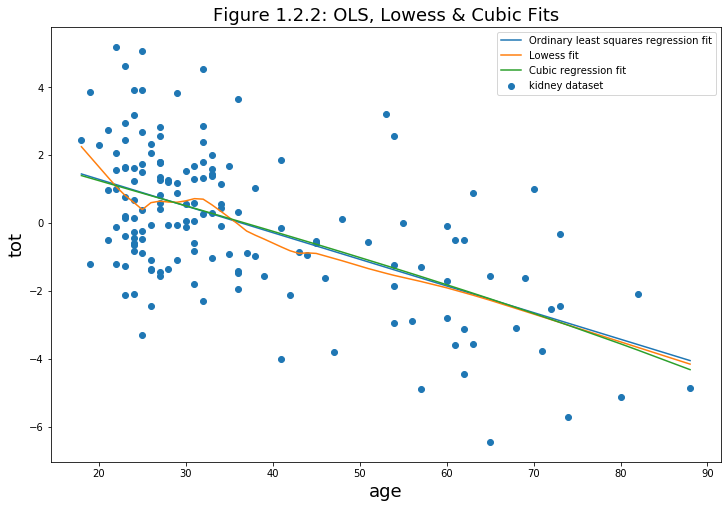

In [7]:
# Figure 1.2.2
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(kidney.age, kidney.tot)
ax.plot(sorted_kidney.age, OLS_tot_pred)
ax.plot(low_preds[:, 0], low_preds[:, 1])
ax.plot(sorted_kidney.age, cubic_tot_pred)

ax.set_title("Figure 1.2.2: OLS, Lowess & Cubic Fits", size=18)
ax.legend(['Ordinary least squares regression fit', 'Lowess fit', 'Cubic regression fit', 'kidney dataset'])
ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18);

## Chapter 1 - Exercice 1.b

#### As shown in Table 1.1 and Figure 1.2.3, the cubic regression results are similar to those of Lowess and OLS regressions. 



Table 1.1:
                                           age
                        -----------------------------------------
                          20    30    40    50    60    70    80
-----------------------------------------------------------------
 1. linear regression   1.29  0.50 -0.28 -1.07 -1.86 -2.64 -3.43
 2. std error           0.21  0.15  0.15  0.19  0.26  0.34  0.42

 3. lowess              1.66  0.65 -0.59 -1.27 -1.91 -2.68 -3.50
 4. boostrap std error  0.68  0.25  0.34  0.32  0.39  0.50  0.69

 5. cubic regression    1.25  0.51 -0.24 -1.01 -1.82 -2.66 -3.56
 6. std error           0.20  0.16  0.15  0.19  0.25  0.34  0.43




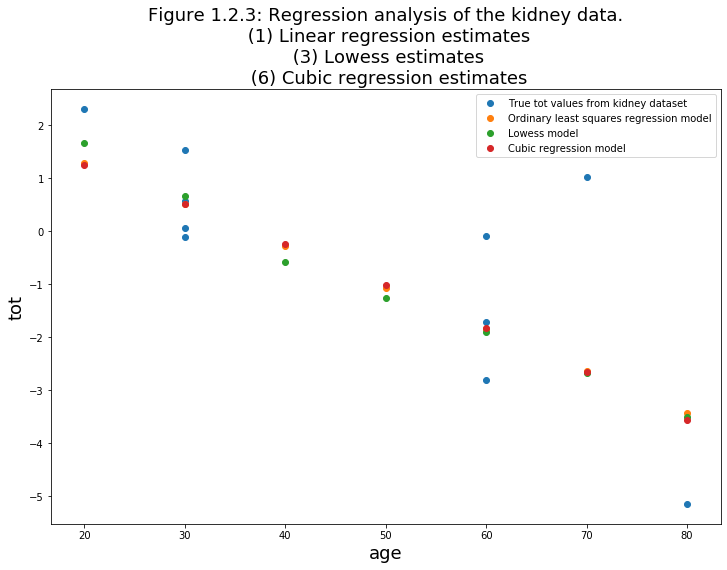

In [8]:
# True kidney tot values at ages 20, 30, ..., 80
#print("age, tot")
true_age = []
true_tot = []
for i in range(kidney.count().age):
    if kidney.age[i] in decades.values:
        #print(str(kidney.age[i]) + ", " + str(kidney.tot[i]))
        true_age.append(kidney.age[i])
        true_tot.append(kidney.tot[i])

# Table 1.1
'''We expect the boostrap standard errors to be close to the book's values, but
not exactly the same, due to randomness and the fact that only 250 bootstrap
samples were used'''

tmplt = " {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f}"
print("\n")
print("Table 1.1:")
print("                                           age")
print("                        -----------------------------------------")
print("                          20    30    40    50    60    70    80")
print("-" * 65)
print(" 1. linear regression " + tmplt.format(*OLS_pred_info["mean"]))
print(" 2. std error         " + tmplt.format(*OLS_pred_info["mean_se"]))
print()
print(" 3. lowess            " + tmplt.format(*interpolate(ages)))
print(" 4. boostrap std error" + tmplt.format(*low_sds))
print()
print(" 5. cubic regression  " + tmplt.format(*cubic_pred_info2["mean"]))
print(" 6. std error         " + tmplt.format(*cubic_pred_info2["mean_se"]))
print("\n")

# Figure 1.2.3
compare_fig, compare_ax = plt.subplots(figsize=(12,8))
compare_ax.scatter(true_age, true_tot)
compare_ax.scatter(decades, OLS_pred_info["mean"].values)
compare_ax.scatter(decades, interpolate(ages))
compare_ax.scatter(decades, cubic_pred_info2["mean"].values)

compare_ax.set_title("Figure 1.2.3: Regression analysis of the kidney data.\n (1) Linear regression estimates\n (3) Lowess estimates\n (6) Cubic regression estimates", size=18)
compare_ax.legend(['True tot values from kidney dataset', 'Ordinary least squares regression model','Lowess model','Cubic regression model'])
compare_ax.set_xlabel("age", size=18)
compare_ax.set_ylabel("tot", size=18);

## Chapter 1 - Exercice 2

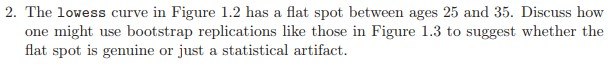

In [7]:
display(Image(filename='./directions/1.2.jpg'))

#### [TODO: give explanation] The flat spot is genuine/a statistical artifact, since ...

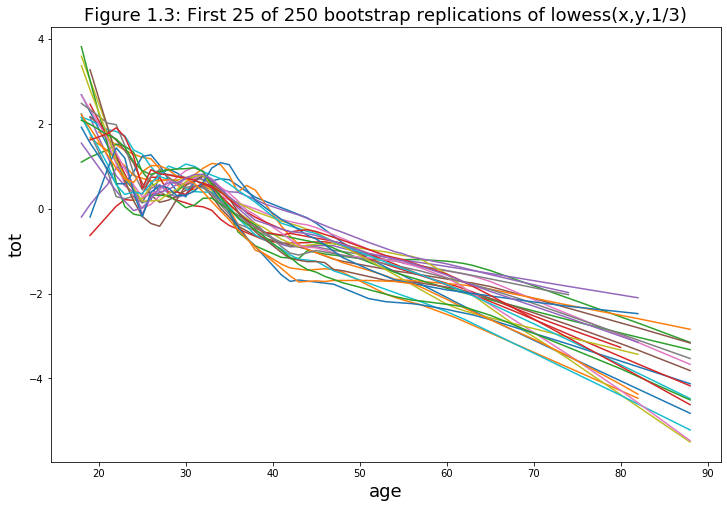

In [9]:
# Figure 1.3
fig, ax = plt.subplots(figsize=(12,8))

for preds in low_boots[:25]:
    ax.plot(preds[:, 0], preds[:, 1])

ax.set_title("Figure 1.3: First 25 of 250 bootstrap replications of lowess(x,y,1/3)", size=18)
ax.set_xlabel("age", size=18)
ax.set_ylabel("tot", size=18);

## Chapter 1 - Exercice 3

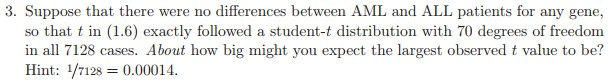

In [8]:
display(Image(filename='./directions/1.3.jpg'))

#### Since it is assumed that there are no differences between AML and ALL patients for any gene, the t values will be around 0 (zero). A t value of 0 states that the sample results exactly equal the null hypothesis. As the difference between the sample data and the null hypothesis increases, the absolute value of the t-value increases.

In [10]:
'''Leukemia data
Gene expression measurements on 72 leukemia patients, 47 "ALL" (see section
1.2), 25 "AML". These data arise from the landmark Golub et al (1999) Science
paper.

There is a larger set consisting of 7128 genes, which was used in Chapters 1,
10, 11, and possibly elsewhere. It is stored as the 7128 x 72 matrix (10MB)
leukemia_big.csv, with the column names denoting the class labels. The
histograms in Figure 1.4 arise from row 136 of this matrix, and the histogram
in Figure 1.5 is of the 7128 two-sample t-test statistics on the rows (genes).
The data can be read directly into R via the command leukemia_big <- read.csv("
http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv")

There is also a smaller subset of these data, consisting of 3571 genes, used in
Section 19.1. It is stored as the 3571 x 72 matrix (5MB) leukemia_small.csv,
with again the column names denoting the class labels. The data can be read
directly into R via the command leukemia_small <- read.csv("http://web.stanford
.edu/~hastie/CASI_files/DATA/leukemia_small.csv")

Disclaimer: these data come with a data analysis challenge.
The columns of the two datasets are in different order. Furthermore, the genes
in the big dataset have been transformed, with the exact transformation used
lost in time. We also do not know the correspondence between the 3157 and 7128
genes. The first person to solve this puzzle completely will be thanked and
their name will appear forever on this page.'''

# load the data
#leukemia_big = pd.read_csv(__data__ + "leukemia_big.csv")
#leukemia_small = pd.read_csv(__data__ + "leukemia_small.csv")
leukemia_big = pd.read_csv("./data/leukemia_big.csv")
#leukemia_small = pd.read_csv("./data/leukemia_small.csv")

# Collect ALL and AML values
cols_all_big = [col for col in leukemia_big.columns if col.startswith("ALL")]
values_all_big = leukemia_big.loc[135, cols_all_big].values

cols_aml_big = [col for col in leukemia_big.columns if col.startswith("AML")]
values_aml_big = leukemia_big.loc[135, cols_aml_big].values

#cols_all_small = [col for col in leukemia_small.columns if col.startswith("ALL")]
#values_all_small = leukemia_small.loc[135, cols_all_small].values

#cols_aml_small = [col for col in leukemia_small.columns if col.startswith("AML")]
#values_aml_small = leukemia_small.loc[135, cols_aml_small].values

# t-test
t_val_big, p_val_big = stats.ttest_ind(values_aml_big, values_all_big)
#t_val_small, p_val_small = stats.ttest_ind(values_aml_small, values_all_small)

print("leukemia_big.csv t-test:")
print("t = {:>.2f};  p = {:>.4f}".format(t_val_big, p_val_big))
print()
#print("leukemia_small.csv t-test:")
#print("t = {:>.2f};  p = {:>.4f}".format(t_val_small, p_val_small))
#print()

leukemia_big.csv t-test:
t = 3.01;  p = 0.0036



Text(0, 0.5, 'Frequency')

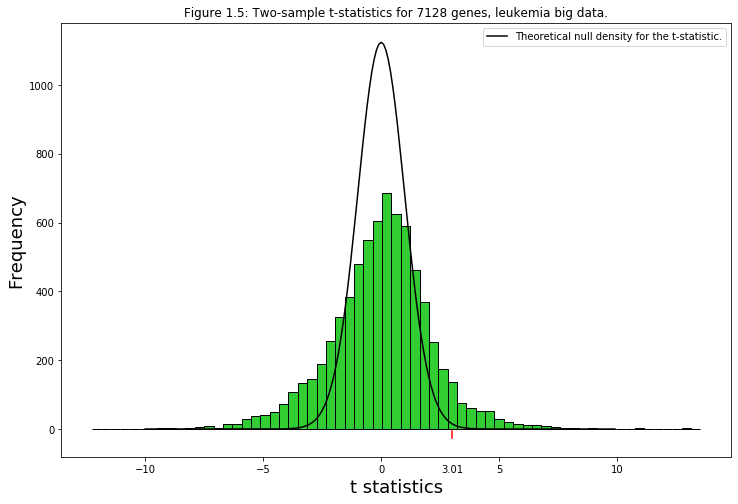

In [11]:
# t statistics
t_values_big = []
for _, row in leukemia_big.iterrows():
    values_all_big = row[cols_all_big].values
    values_aml_big = row[cols_aml_big].values
    t_big, _ = stats.ttest_ind(values_aml_big, values_all_big)
    t_values_big.append(t_big)
    
##t_values_small = []
#for _, row in leukemia_small.iterrows():
#    values_all_small = row[cols_all_small].values
#    values_aml_small = row[cols_aml_small].values
#    t_small, _ = stats.ttest_ind(values_aml_small, values_all_small)
#    t_values_small.append(t_small)
    
# Distrubtion values
dist_x = np.arange(-10, 10, 0.1)
dist_t = stats.t.pdf(dist_x, df=70)

# Figure 1.5 - Plot BIG
fig, ax = plt.subplots(figsize=(12, 8))

hist_info_big = ax.hist(t_values_big, bins=65, edgecolor="k", facecolor="limegreen")
bin_y_big, bin_x_big = hist_info_big[0], hist_info_big[1]
hist_area_big = ((bin_x_big[1:] - bin_x_big[:-1]) * bin_y_big).sum()

ax.plot(dist_x, dist_t * hist_area_big, c="k")

ax.set_xticks([t_val_big], minor=True)
ax.set_xticklabels([np.round(t_val_big, 2)], minor=True)
ax.tick_params(axis='both', which='minor', length=4, color="white")

ax.plot([t_val_big, t_val_big], [-5, -25], c="r")

ax.set_title("Figure 1.5: Two-sample t-statistics for 7128 genes, leukemia big data.")
ax.legend(['Theoretical null density for the t-statistic.'])
ax.set_xlabel("t statistics", size=18)
ax.set_ylabel("Frequency", size=18)
#ax.set_ylim(-30, 720);

## Figure 1.5.1 - Plot SMALL
#fig, ax = plt.subplots(figsize=(12, 8))
#
#hist_info_small = ax.hist(t_values_small, bins=65, edgecolor="k", facecolor="limegreen")
#bin_y_small, bin_x_small = hist_info_small[0], hist_info_small[1]
#hist_area_small = ((bin_x_small[1:] - bin_x_small[:-1]) * bin_y_small).sum()
#
#ax.plot(dist_x, dist_t * hist_area_small, c="k")
#
#ax.set_xticks([t_val_small], minor=True)
#ax.set_xticklabels([np.round(t_val_small, 2)], minor=True)
#ax.tick_params(axis='both', which='minor', length=4, color="white")
#
#ax.plot([t_val_small, t_val_small], [-5, -25], c="r")
#
#ax.set_title("Figure 1.5.1: Two-sample t-statistics for 3571 genes, leukemia small data.")
#ax.legend(['Theoretical null density for the t-statistic.'])
#ax.set_xlabel("t statistics", size=18)
#ax.set_ylabel("Frequency", size=18)
#ax.set_ylim(-30, 720);

## Chapter 1 - Exercice 4.a, 4.b & 4.c

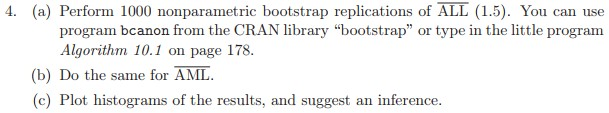

In [9]:
display(Image(filename='./directions/1.4.jpg'))

#### [TODO: suggest an inference] 

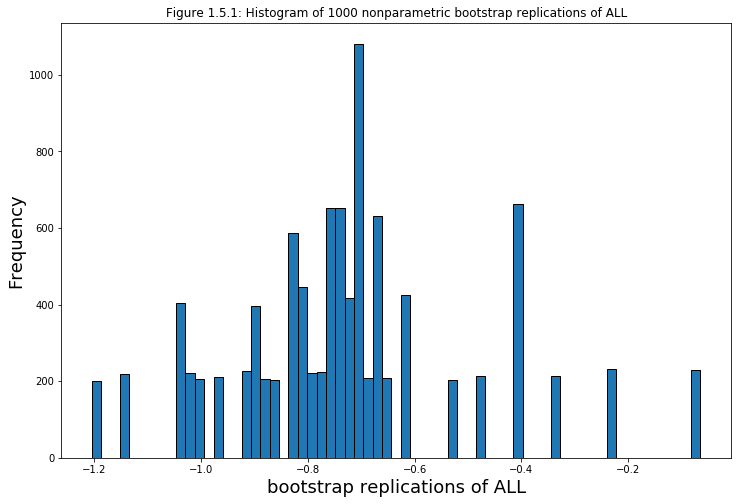

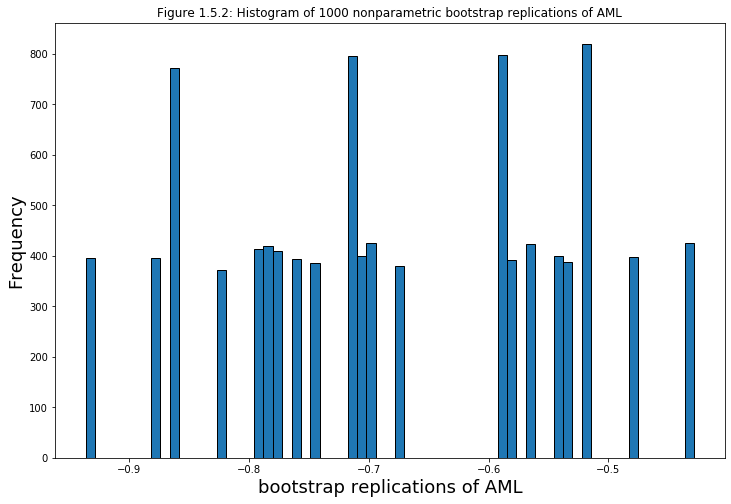

In [14]:
 def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    
    # Why didn't that work? Because Pandas has silently dealt with the rows for
    # which the indices are missing, returning NaNs, and then silently deat
    # with the NaNs, dropping them from the average calculation.
    if isinstance(X, pd.Series):
        X = X.copy()
        X.index = range(len(X.index))
    
    # n equal to len(X) if n==None
    if n == None:
        n = len(X)
    
    # Bootstrap resample
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    return X_resample

# Perform 1000 nonparametric bootstrap replications of ALL & AML
ALL_BootstrapReplications = bootstrap_resample(values_all_big, n=10000)
AML_BootstrapReplications = bootstrap_resample(values_aml_big, n=10000)

# Figure 1.5.1
ALL_fig, ALL_ax = plt.subplots(figsize=(12, 8))
ALL_hist = ALL_ax.hist(ALL_BootstrapReplications, bins=65, edgecolor="k")
ALL_ax.set_title("Figure 1.5.1: Histogram of 1000 nonparametric bootstrap replications of ALL")
ALL_ax.set_xlabel("bootstrap replications of ALL", size=18)
ALL_ax.set_ylabel("Frequency", size=18);

# Figure 1.5.2
AML_fig, AML_ax = plt.subplots(figsize=(12, 8))
AML_hist = AML_ax.hist(AML_BootstrapReplications, bins=65, edgecolor="k")
AML_ax.set_title("Figure 1.5.2: Histogram of 1000 nonparametric bootstrap replications of AML")
AML_ax.set_xlabel("bootstrap replications of AML", size=18)
AML_ax.set_ylabel("Frequency", size=18);

# Chapter 2

## Chapter 2 - Exercice 1

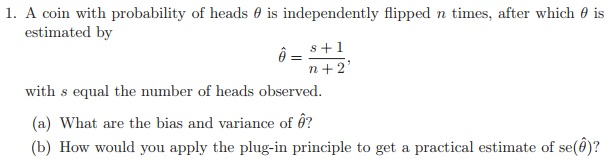

In [10]:
display(Image(filename='./directions/2.1.jpg'))

## Chapter 2 - Exercice 2

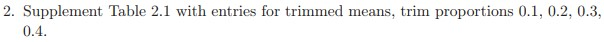

In [11]:
display(Image(filename='./directions/2.2.jpg'))

## Chapter 2 - Exercice 3

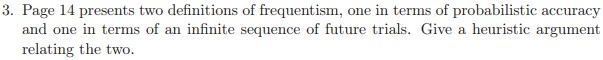

In [12]:
display(Image(filename='./directions/2.3.jpg'))

## Chapter 2 - Exercice 4

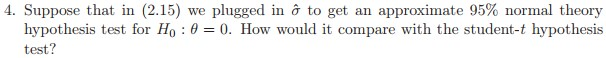

In [13]:
display(Image(filename='./directions/2.4.jpg'))

## Chapter 2 - Exercice 5

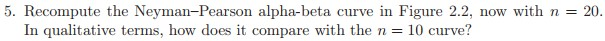

In [14]:
display(Image(filename='./directions/2.5.jpg'))